In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


In [2]:
# generated by ChatGPT
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using device:", device)


Using device: cuda


In [3]:
class WeatherDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.transform = transform
        # Search recursively for jpg images
        self.image_paths = glob.glob(os.path.join(root_dir, '**/*.jpg'), recursive=True)
        print(f"Found {len(self.image_paths)} images.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            image = Image.new('RGB', (32, 32), (0, 0, 0))
        if self.transform:
            image = self.transform(image)
        return image

# Define transformations: resize to 32x32, convert to tensor, normalize to [-1,1]
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Set your dataset root and create DataLoader.
dataset_root = "./archive/"
weather_dataset = WeatherDataset(root_dir=dataset_root, transform=transform)
batch_size = 128
dataloader = DataLoader(weather_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

Found 819 images.


In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim=256):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder: For 32x32 input
        # 32x32 -> 16x16 -> 8x8 -> 4x4 -> 2x2
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 3x32x32 -> 32x16x16
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),   # 32x16x16 -> 64x8x8
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 64x8x8 -> 128x4x4
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 128x4x4 -> 256x2x2
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # Now the flattened feature map size is 256*2*2 = 1024
        self.flatten_dim = 256 * 2 * 2
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

        # Decoder: Upsample from 2x2 to 32x32
        self.decoder_input = nn.Linear(latent_dim, self.flatten_dim)
        self.decoder = nn.Sequential(
            # Upsample from 2x2 to 4x4
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1),  # 256x2x2 -> 256x4x4
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # Upsample from 4x4 to 8x8
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 256x4x4 -> 128x8x8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Upsample from 8x8 to 16x16
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 128x8x8 -> 64x16x16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # Upsample from 16x16 to 32x32
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),     # 64x16x16 -> 3x32x32
            nn.Tanh()  # Output normalized to [-1,1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        batch_size = x.size(0)
        enc_out = self.encoder(x)
        enc_out = enc_out.view(batch_size, -1)
        mu = self.fc_mu(enc_out)
        logvar = self.fc_logvar(enc_out)
        z = self.reparameterize(mu, logvar)

        dec_input = self.decoder_input(z)
        dec_input = dec_input.view(batch_size, 256, 2, 2)
        reconstruction = self.decoder(dec_input)
        return reconstruction, mu, logvar


In [5]:
def loss_function(recon_x, x, mu, logvar):
    # Mean Squared Error loss for reconstruction
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

vae = VAE(latent_dim=256).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [31]:
num_epochs = 20000  # Adjust as needed
vae.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(batch)
        loss = loss_function(recon_batch, batch, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_loss = train_loss / len(weather_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/20000, Loss: 73.3811
Epoch 2/20000, Loss: 74.0107
Epoch 3/20000, Loss: 74.1441
Epoch 4/20000, Loss: 73.9308
Epoch 5/20000, Loss: 73.9938
Epoch 6/20000, Loss: 73.3516
Epoch 7/20000, Loss: 73.6751
Epoch 8/20000, Loss: 73.7477
Epoch 9/20000, Loss: 73.7871
Epoch 10/20000, Loss: 74.0233
Epoch 11/20000, Loss: 73.8353
Epoch 12/20000, Loss: 74.3007
Epoch 13/20000, Loss: 74.5129
Epoch 14/20000, Loss: 73.8445
Epoch 15/20000, Loss: 73.6970
Epoch 16/20000, Loss: 73.5304
Epoch 17/20000, Loss: 73.5254
Epoch 18/20000, Loss: 73.8559
Epoch 19/20000, Loss: 74.2573
Epoch 20/20000, Loss: 73.6574
Epoch 21/20000, Loss: 73.4679
Epoch 22/20000, Loss: 73.7902
Epoch 23/20000, Loss: 73.4569
Epoch 24/20000, Loss: 74.0783
Epoch 25/20000, Loss: 73.4816
Epoch 26/20000, Loss: 73.8160
Epoch 27/20000, Loss: 73.2039
Epoch 28/20000, Loss: 73.5161
Epoch 29/20000, Loss: 73.5376
Epoch 30/20000, Loss: 73.2712
Epoch 31/20000, Loss: 73.6622
Epoch 32/20000, Loss: 73.6564
Epoch 33/20000, Loss: 73.8871
Epoch 34/20000, Los

KeyboardInterrupt: 

In [32]:
# After training, save the VAE's state dictionary
torch.save(vae.state_dict(), "vaepocket.pth")
print("VAE model saved!")

VAE model saved!


VAE model loaded!


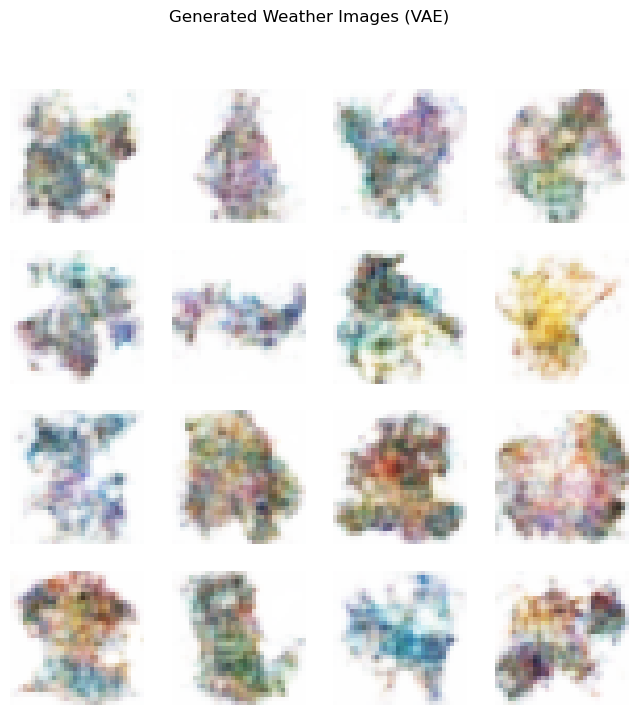

In [33]:
# Initialize the VAE and load the saved weights
vae = VAE(latent_dim=256).to(device)
# Use weights_only=True for safer loading (if supported)
vae.load_state_dict(torch.load("vaepocket.pth", map_location=device, weights_only=True))
vae.eval()  # Set the model to evaluation mode

print("VAE model loaded!")

# Generate images from the VAE

n_samples = 16
# Sample latent vectors of dimension 256
sampled_z = torch.randn(n_samples, 256).to(device)
with torch.no_grad():
    # Pass the latent vectors through the decoder input layer
    dec_input = vae.decoder_input(sampled_z)
    # Reshape to (n_samples, 256, 2, 2) as expected by the decoder
    dec_input = dec_input.view(n_samples, 256, 2, 2)
    # Generate images using the decoder
    generated = vae.decoder(dec_input).cpu()

# Denormalize images from [-1, 1] to [0, 1]
generated = (generated + 1) / 2

# Plot the generated images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    # Transpose to (height, width, channels) for imshow
    ax.imshow(np.transpose(generated[i].numpy(), (1, 2, 0)))
    ax.axis('off')
plt.suptitle("Generated Weather Images (VAE)")
plt.show()

In [15]:
# Generator

class Generator(nn.Module):
    def __init__(self, nz=100):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: latent vector Z of shape (nz, 1, 1)
            nn.ConvTranspose2d(nz, 256, kernel_size=4, stride=1, padding=0, bias=False),
            # Output: 256 x 4 x 4
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            # Output: 128 x 8 x 8
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            # Output: 64 x 16 x 16
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            # Output: 3 x 32 x 32
            nn.Tanh()  # outputs normalized to [-1, 1]
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: 3 x 32 x 32
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            # Output: 64 x 16 x 16
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            # Output: 128 x 8 x 8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            # Output: 256 x 4 x 4
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # Output: 1 x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)


In [16]:
nz = 100  # dimension of noise vector
netG = Generator(nz=nz).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()
lr = 0.0002
beta1 = 0.5

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

num_epochs_gan = 20000  # Increase for better results!
real_label = 1.
fake_label = 0.


In [41]:
print("Starting GAN Training...")
for epoch in range(num_epochs_gan):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()
        # Train with real images
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()

        # Train with fake images
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # Generator wants discriminator to label as real
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

    print(f"[{epoch+1}/{num_epochs_gan}] Loss_D: {(errD_real+errD_fake).item():.4f} Loss_G: {errG.item():.4f}")


Starting GAN Training...
[1/20000] Loss_D: 100.0000 Loss_G: 0.0000
[2/20000] Loss_D: 100.0000 Loss_G: 0.0000
[3/20000] Loss_D: 100.0000 Loss_G: 0.0000
[4/20000] Loss_D: 100.0000 Loss_G: 0.0000
[5/20000] Loss_D: 100.0000 Loss_G: 0.0000
[6/20000] Loss_D: 100.0000 Loss_G: 0.0000
[7/20000] Loss_D: 100.0000 Loss_G: 0.0000
[8/20000] Loss_D: 100.0000 Loss_G: 0.0000
[9/20000] Loss_D: 100.0000 Loss_G: 0.0000
[10/20000] Loss_D: 100.0000 Loss_G: 0.0000
[11/20000] Loss_D: 100.0000 Loss_G: 0.0000
[12/20000] Loss_D: 100.0000 Loss_G: 0.0000
[13/20000] Loss_D: 100.0000 Loss_G: 0.0000
[14/20000] Loss_D: 100.0000 Loss_G: 0.0000
[15/20000] Loss_D: 100.0000 Loss_G: 0.0000
[16/20000] Loss_D: 100.0000 Loss_G: 0.0000
[17/20000] Loss_D: 100.0000 Loss_G: 0.0000
[18/20000] Loss_D: 100.0000 Loss_G: 0.0000
[19/20000] Loss_D: 100.0000 Loss_G: 0.0000
[20/20000] Loss_D: 100.0000 Loss_G: 0.0000
[21/20000] Loss_D: 100.0000 Loss_G: 0.0000
[22/20000] Loss_D: 100.0000 Loss_G: 0.0000
[23/20000] Loss_D: 100.0000 Loss_G: 0.

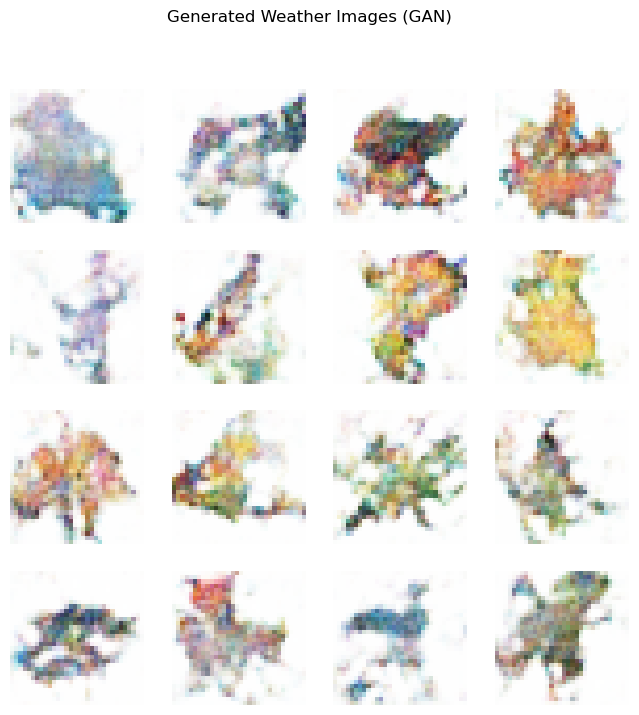

In [42]:
# Generate images from the GAN
netG.eval()
n_samples = 16
noise = torch.randn(n_samples, nz, 1, 1, device=device)
with torch.no_grad():
    fake_images = netG(noise).cpu()

# Denormalize from [-1,1] to [0,1]
fake_images = (fake_images + 1) / 2

# Plot the generated images
fig, axes = plt.subplots(4, 4, figsize=(8,8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(np.transpose(fake_images[i].numpy(), (1,2,0)))
    ax.axis('off')
plt.suptitle("Generated Weather Images (GAN)")
plt.show()


In [20]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nz = 100  # dimension of noise vector (must match training)

# Create generator instance and load the saved weights
netG = Generator(nz=nz).to(device)
netG.load_state_dict(torch.load("netGpocket.pth", map_location=device, weights_only=True))

netG.eval()  # set to evaluation mode

print("Generator loaded!")


Generator loaded!


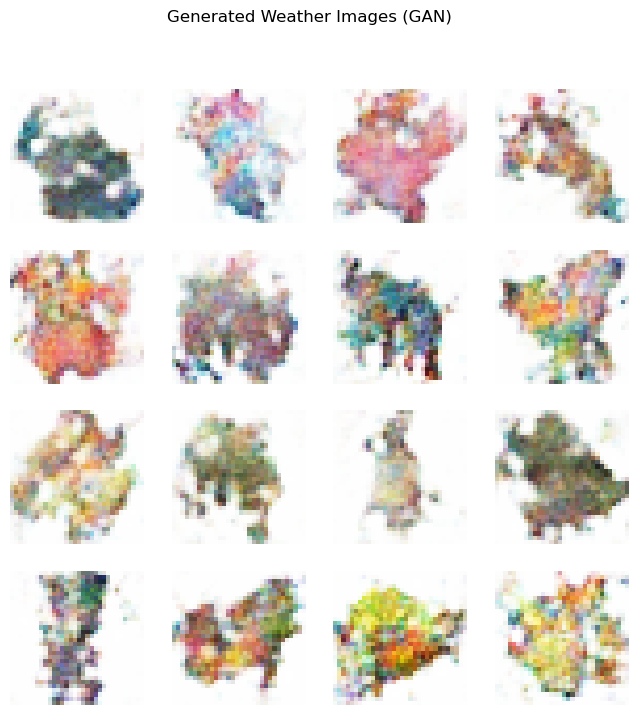

In [27]:
import matplotlib.pyplot as plt
import numpy as np

n_samples = 16
noise = torch.randn(n_samples, nz, 1, 1, device=device)  # create latent noise vectors

with torch.no_grad():
    fake_images = netG(noise).cpu()  # generate images

# Denormalize from [-1,1] to [0,1]
fake_images = (fake_images + 1) / 2

# Plot the generated images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(np.transpose(fake_images[i].numpy(), (1, 2, 0)))
    ax.axis('off')
plt.suptitle("Generated Weather Images (GAN)")
plt.show()


In [43]:
# Save the generator and discriminator state dictionaries
torch.save(netG.state_dict(), "netGpocket.pth")
torch.save(netD.state_dict(), "netDpocket.pth")
print("Models saved!")

Models saved!
